### Let's combine all stages and implement simple model training cycle

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import v2

import os
import matplotlib.pyplot as plt
import numpy as np

import json
from tqdm import tqdm
from PIL import Image

plt.style.use('seaborn-v0_8-dark-palette')

#### Define device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#### Create Dataset

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.len_dataset = 0
        self.data_list = []

        for path_dir, dir_list, file_list in os.walk(path):
            if path_dir == path:
                self.classes = sorted(dir_list)
                self.class_to_index = {
                    cls_name: i for i, cls_name in enumerate(self.classes)
                }
                continue

            cls = path_dir.split('/')[-1]

            for name_file in file_list:
                file_path = os.path.join(path_dir, name_file)
                self.data_list.append((file_path, self.class_to_index[cls]))

            self.len_dataset += len(file_list)

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        file_path, target = self.data_list[index]
        sample = np.array(Image.open(file_path))

        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [4]:
# transform data
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5,), std=(0.5,))
    ]
)

In [5]:
# create datasets
# note: you need to run scripts from dataloader part
path = os.path.join(os.getcwd(), 'mnist')
train_data = MNISTDataset(os.path.join(path, 'training'), transform=transform)
test_data = MNISTDataset(os.path.join(path, 'testing'), transform=transform)

In [6]:
# split data
train_data, val_data = random_split(train_data, [0.7, 0.3])

In [7]:
# split data on batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

#### Create model

In [8]:
class MyModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 128)
        self.layer_2 = nn.Linear(128, output)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)
        return out

In [9]:
model = MyModel(784, 10).to(device)

In [10]:
# check
input = torch.rand([16, 784], dtype=torch.float32).to(device)

out = model(input)
out.shape

torch.Size([16, 10])

In [11]:
# set up loss and GD optimizer
loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

#### Create train cycle

In [12]:
EPOCHS = 100
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# train cycle
for epoch in range(EPOCHS):

    # train our model
    model.train() # put model into training mode
    # we will save our loss
    running_train_loss = []
    # implement metric(accuracy)
    true_answer = 0
    # add progress bar
    train_loop = tqdm(train_loader, leave=False)
    for x, targets in train_loop:
        # Data(watch on shapes)
        # (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.reshape(-1, 28 * 28).to(device)
        # (batch_size, int) -> (batch_size, 10, dtype=float32)
        targets = targets.reshape(-1).to(torch.int32)
        targets = torch.eye(10)[targets].to(device)
        
        # forward pass + loss calculation
        pred = model(x)
        loss = loss_model(pred, targets)

        # Backward pass
        opt.zero_grad()
        loss.backward()
        # Optimizing step
        opt.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss) / len(running_train_loss)

        true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
        
        # set description to progress bar
        train_loop.set_description(f'Epoch [{epoch + 1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}')

    # calc accuracy
    running_train_accuracy = true_answer / len(train_data)
    
    # save loss and metric
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_accuracy)
    
    # check model quality(validation)
    model.eval() # put model in validation mode
    with torch.no_grad(): # disable gradient calculation
        # save loss on validation
        running_val_loss = []
        true_answer = 0
        for x, targets in val_loader:
            # data
            # (batch_size, 1, 28, 28) -> (batch_size, 784)
            x = x.reshape(-1, 28 * 28).to(device)
            # (batch_size, int) -> (batch_size, 10, dtype=float32)
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(10)[targets].to(device)

            # forward pass + calc loss
            pred = model(x)
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss) / len(running_val_loss)

            true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
            
        # calc metric(accuracy)
        running_val_acc = true_answer / len(val_data)
            
        # save loss and metrics
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)

        print(f'Epoch [{epoch + 1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}, train_acc = {running_train_accuracy:.4f}, val_loss = {mean_val_loss:.4f}, val_acc = {running_val_acc:.4f}')

Epoch [1/100], train_loss = 0.4316, train_acc = 0.8760, val_loss = 0.3129, val_acc = 0.9053


Epoch [2/100], train_loss = 0.2345, train_acc = 0.9305, val_loss = 0.2077, val_acc = 0.9378


Epoch [3/100], train_loss = 0.1689, train_acc = 0.9486, val_loss = 0.1710, val_acc = 0.9514


Epoch [4/100], train_loss = 0.1316, train_acc = 0.9604, val_loss = 0.1529, val_acc = 0.9575


Epoch [5/100], train_loss = 0.1121, train_acc = 0.9655, val_loss = 0.1308, val_acc = 0.9612


Epoch [6/100], train_loss = 0.0948, train_acc = 0.9716, val_loss = 0.1249, val_acc = 0.9639


Epoch [7/100], train_loss = 0.0871, train_acc = 0.9732, val_loss = 0.1169, val_acc = 0.9663


Epoch [8/100], train_loss = 0.0775, train_acc = 0.9755, val_loss = 0.1039, val_acc = 0.9698


Epoch [9/100], train_loss = 0.0667, train_acc = 0.9788, val_loss = 0.0984, val_acc = 0.9723


Epoch [10/100], train_loss = 0.0629, train_acc = 0.9797, val_loss = 0.1011, val_acc = 0.9717


Epoch [11/100], train_loss = 0.0554, train_acc = 0.9830, val_loss = 0.1137, val_acc = 0.9678


Epoch [12/100], train_loss = 0.0540, train_acc = 0.9829, val_loss = 0.1072, val_acc = 0.9699


Epoch [13/100], train_loss = 0.0473, train_acc = 0.9850, val_loss = 0.1142, val_acc = 0.9667


Epoch [14/100], train_loss = 0.0459, train_acc = 0.9851, val_loss = 0.1239, val_acc = 0.9669


Epoch [15/100], train_loss = 0.0408, train_acc = 0.9866, val_loss = 0.1100, val_acc = 0.9724


Epoch [16/100], train_loss = 0.0386, train_acc = 0.9874, val_loss = 0.1137, val_acc = 0.9711


Epoch [17/100], train_loss = 0.0333, train_acc = 0.9892, val_loss = 0.1136, val_acc = 0.9682


Epoch [18/100], train_loss = 0.0360, train_acc = 0.9876, val_loss = 0.1209, val_acc = 0.9694


Epoch [19/100], train_loss = 0.0293, train_acc = 0.9903, val_loss = 0.1060, val_acc = 0.9736


Epoch [20/100], train_loss = 0.0301, train_acc = 0.9897, val_loss = 0.1115, val_acc = 0.9719


Epoch [21/100], train_loss = 0.0251, train_acc = 0.9912, val_loss = 0.1136, val_acc = 0.9727


Epoch [22/100], train_loss = 0.0268, train_acc = 0.9911, val_loss = 0.1344, val_acc = 0.9682


Epoch [23/100], train_loss = 0.0249, train_acc = 0.9917, val_loss = 0.1262, val_acc = 0.9691


Epoch [24/100], train_loss = 0.0229, train_acc = 0.9920, val_loss = 0.1191, val_acc = 0.9717


Epoch [25/100], train_loss = 0.0220, train_acc = 0.9928, val_loss = 0.1161, val_acc = 0.9735


Epoch [26/100], train_loss = 0.0224, train_acc = 0.9920, val_loss = 0.1156, val_acc = 0.9732


Epoch [27/100], train_loss = 0.0191, train_acc = 0.9934, val_loss = 0.1322, val_acc = 0.9690


Epoch [28/100], train_loss = 0.0174, train_acc = 0.9943, val_loss = 0.1198, val_acc = 0.9726


Epoch [29/100], train_loss = 0.0190, train_acc = 0.9934, val_loss = 0.1414, val_acc = 0.9696


Epoch [30/100], train_loss = 0.0147, train_acc = 0.9954, val_loss = 0.1222, val_acc = 0.9727


Epoch [31/100], train_loss = 0.0177, train_acc = 0.9936, val_loss = 0.1278, val_acc = 0.9729


Epoch [32/100], train_loss = 0.0146, train_acc = 0.9951, val_loss = 0.1347, val_acc = 0.9716


Epoch [33/100], train_loss = 0.0172, train_acc = 0.9942, val_loss = 0.1681, val_acc = 0.9663


Epoch [34/100], train_loss = 0.0173, train_acc = 0.9937, val_loss = 0.1439, val_acc = 0.9714


Epoch [35/100], train_loss = 0.0145, train_acc = 0.9950, val_loss = 0.1474, val_acc = 0.9711


Epoch [36/100], train_loss = 0.0142, train_acc = 0.9950, val_loss = 0.1686, val_acc = 0.9671


Epoch [37/100], train_loss = 0.0132, train_acc = 0.9958, val_loss = 0.1405, val_acc = 0.9732


Epoch [38/100], train_loss = 0.0170, train_acc = 0.9946, val_loss = 0.1486, val_acc = 0.9717


Epoch [39/100], train_loss = 0.0160, train_acc = 0.9940, val_loss = 0.1584, val_acc = 0.9694


Epoch [40/100], train_loss = 0.0116, train_acc = 0.9959, val_loss = 0.1478, val_acc = 0.9735


Epoch [41/100], train_loss = 0.0118, train_acc = 0.9958, val_loss = 0.1511, val_acc = 0.9729


Epoch [42/100], train_loss = 0.0115, train_acc = 0.9962, val_loss = 0.1524, val_acc = 0.9726


Epoch [43/100], train_loss = 0.0158, train_acc = 0.9946, val_loss = 0.1637, val_acc = 0.9697


Epoch [44/100], train_loss = 0.0096, train_acc = 0.9966, val_loss = 0.1448, val_acc = 0.9736


Epoch [45/100], train_loss = 0.0140, train_acc = 0.9951, val_loss = 0.1544, val_acc = 0.9711


Epoch [46/100], train_loss = 0.0102, train_acc = 0.9964, val_loss = 0.1611, val_acc = 0.9698


Epoch [47/100], train_loss = 0.0128, train_acc = 0.9955, val_loss = 0.1594, val_acc = 0.9725


Epoch [48/100], train_loss = 0.0139, train_acc = 0.9955, val_loss = 0.1866, val_acc = 0.9682


Epoch [49/100], train_loss = 0.0104, train_acc = 0.9964, val_loss = 0.1635, val_acc = 0.9731


Epoch [50/100], train_loss = 0.0110, train_acc = 0.9959, val_loss = 0.1681, val_acc = 0.9714


Epoch [51/100], train_loss = 0.0092, train_acc = 0.9970, val_loss = 0.1514, val_acc = 0.9750


Epoch [52/100], train_loss = 0.0114, train_acc = 0.9961, val_loss = 0.1994, val_acc = 0.9670


Epoch [53/100], train_loss = 0.0134, train_acc = 0.9959, val_loss = 0.1804, val_acc = 0.9714


Epoch [54/100], train_loss = 0.0137, train_acc = 0.9953, val_loss = 0.1534, val_acc = 0.9756


Epoch [55/100], train_loss = 0.0027, train_acc = 0.9991, val_loss = 0.1531, val_acc = 0.9765


Epoch [56/100], train_loss = 0.0134, train_acc = 0.9955, val_loss = 0.1852, val_acc = 0.9700


Epoch [57/100], train_loss = 0.0100, train_acc = 0.9964, val_loss = 0.1922, val_acc = 0.9714


Epoch [58/100], train_loss = 0.0097, train_acc = 0.9966, val_loss = 0.1706, val_acc = 0.9736


Epoch [59/100], train_loss = 0.0121, train_acc = 0.9957, val_loss = 0.1784, val_acc = 0.9736


Epoch [60/100], train_loss = 0.0093, train_acc = 0.9970, val_loss = 0.1901, val_acc = 0.9712


Epoch [61/100], train_loss = 0.0095, train_acc = 0.9967, val_loss = 0.1815, val_acc = 0.9734


Epoch [62/100], train_loss = 0.0097, train_acc = 0.9965, val_loss = 0.1713, val_acc = 0.9752


Epoch [63/100], train_loss = 0.0092, train_acc = 0.9969, val_loss = 0.1941, val_acc = 0.9722


Epoch [64/100], train_loss = 0.0105, train_acc = 0.9963, val_loss = 0.1717, val_acc = 0.9754


Epoch [65/100], train_loss = 0.0039, train_acc = 0.9987, val_loss = 0.1771, val_acc = 0.9748


Epoch [66/100], train_loss = 0.0171, train_acc = 0.9943, val_loss = 0.2172, val_acc = 0.9700


Epoch [67/100], train_loss = 0.0083, train_acc = 0.9971, val_loss = 0.1745, val_acc = 0.9764


Epoch [68/100], train_loss = 0.0016, train_acc = 0.9995, val_loss = 0.1714, val_acc = 0.9750


Epoch [69/100], train_loss = 0.0174, train_acc = 0.9941, val_loss = 0.2177, val_acc = 0.9688


Epoch [70/100], train_loss = 0.0083, train_acc = 0.9973, val_loss = 0.1897, val_acc = 0.9718


Epoch [71/100], train_loss = 0.0077, train_acc = 0.9977, val_loss = 0.2006, val_acc = 0.9718


Epoch [72/100], train_loss = 0.0058, train_acc = 0.9982, val_loss = 0.1970, val_acc = 0.9731


Epoch [73/100], train_loss = 0.0096, train_acc = 0.9968, val_loss = 0.1844, val_acc = 0.9739


Epoch [74/100], train_loss = 0.0143, train_acc = 0.9952, val_loss = 0.2152, val_acc = 0.9707


Epoch [75/100], train_loss = 0.0062, train_acc = 0.9977, val_loss = 0.1853, val_acc = 0.9744


Epoch [76/100], train_loss = 0.0014, train_acc = 0.9996, val_loss = 0.1964, val_acc = 0.9738


Epoch [77/100], train_loss = 0.0155, train_acc = 0.9950, val_loss = 0.1853, val_acc = 0.9756


Epoch [78/100], train_loss = 0.0039, train_acc = 0.9986, val_loss = 0.1983, val_acc = 0.9743


Epoch [79/100], train_loss = 0.0128, train_acc = 0.9960, val_loss = 0.1983, val_acc = 0.9745


Epoch [80/100], train_loss = 0.0050, train_acc = 0.9982, val_loss = 0.2051, val_acc = 0.9731


Epoch [81/100], train_loss = 0.0108, train_acc = 0.9971, val_loss = 0.3291, val_acc = 0.9579


Epoch [82/100], train_loss = 0.0120, train_acc = 0.9964, val_loss = 0.2139, val_acc = 0.9731


Epoch [83/100], train_loss = 0.0059, train_acc = 0.9979, val_loss = 0.2288, val_acc = 0.9699


Epoch [84/100], train_loss = 0.0058, train_acc = 0.9980, val_loss = 0.2277, val_acc = 0.9723


Epoch [85/100], train_loss = 0.0032, train_acc = 0.9989, val_loss = 0.1900, val_acc = 0.9764


Epoch [86/100], train_loss = 0.0161, train_acc = 0.9953, val_loss = 0.2028, val_acc = 0.9732


Epoch [87/100], train_loss = 0.0045, train_acc = 0.9982, val_loss = 0.2148, val_acc = 0.9716


Epoch [88/100], train_loss = 0.0109, train_acc = 0.9961, val_loss = 0.2316, val_acc = 0.9712


Epoch [89/100], train_loss = 0.0048, train_acc = 0.9984, val_loss = 0.1949, val_acc = 0.9763


Epoch [90/100], train_loss = 0.0009, train_acc = 0.9998, val_loss = 0.1877, val_acc = 0.9771


Epoch [91/100], train_loss = 0.0001, train_acc = 1.0000, val_loss = 0.1903, val_acc = 0.9776


Epoch [92/100], train_loss = 0.0000, train_acc = 1.0000, val_loss = 0.1855, val_acc = 0.9782


Epoch [93/100], train_loss = 0.0000, train_acc = 1.0000, val_loss = 0.1861, val_acc = 0.9780


Epoch [94/100], train_loss = 0.0218, train_acc = 0.9961, val_loss = 0.3277, val_acc = 0.9566


Epoch [95/100], train_loss = 0.0153, train_acc = 0.9953, val_loss = 0.2347, val_acc = 0.9728


Epoch [96/100], train_loss = 0.0085, train_acc = 0.9971, val_loss = 0.2288, val_acc = 0.9721


Epoch [97/100], train_loss = 0.0050, train_acc = 0.9981, val_loss = 0.2269, val_acc = 0.9733


Epoch [98/100], train_loss = 0.0112, train_acc = 0.9965, val_loss = 0.2165, val_acc = 0.9751


Epoch [99/100], train_loss = 0.0033, train_acc = 0.9989, val_loss = 0.2073, val_acc = 0.9746


Epoch [100/100], train_loss = 0.0077, train_acc = 0.9975, val_loss = 0.2328, val_acc = 0.9733


#### Plot results

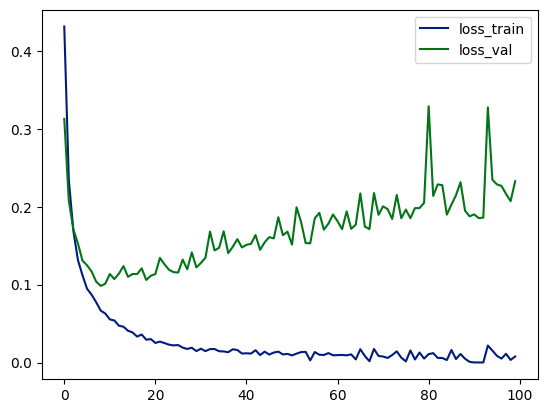

In [13]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

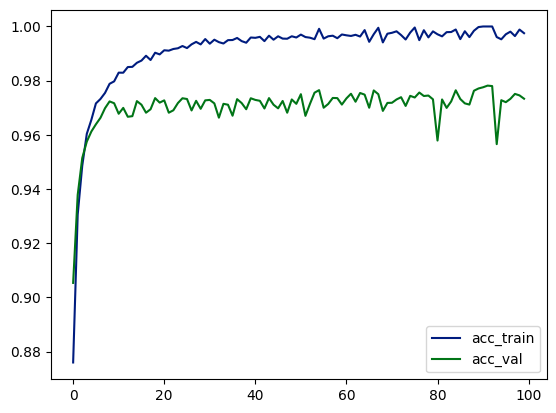

In [14]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['acc_train', 'acc_val'])
plt.show()